## Recap
* Tokenization ✅
* Embedding ✅
* Simplified Self-Attention ✅

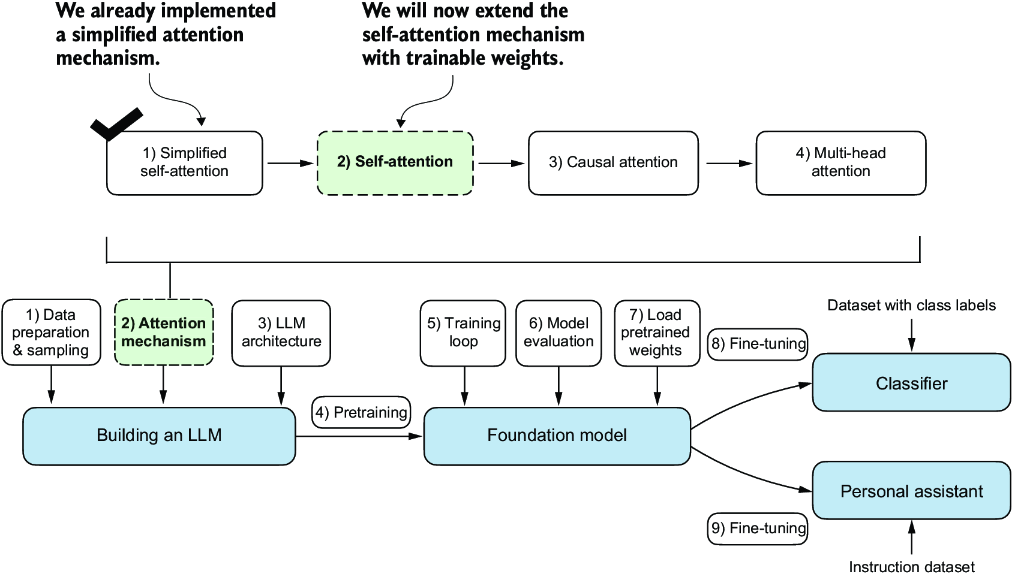

### Pre-processing

In [1]:
import torch
import numpy as np
import onnxruntime as ort
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from tokenizers import Tokenizer
from pathlib import Path
from typing import List

In [2]:
root_dir = Path.cwd()
root_dir

WindowsPath('C:/Users/derrjohn/OneDrive - Qualcomm/Desktop/git/SWRG/Chapter_3')

In [3]:
model_name = "deepseek_r1_1_5_embeddings_quant_v2.0.onnx"
tokenizer = "tokenizer.json"

In [4]:
model_path = root_dir/"resources"/"qnn-deepseek-r1-distill-qwen-1.5b"/model_name
tokenizer_path = root_dir/"resources"/"qnn-deepseek-r1-distill-qwen-1.5b"/tokenizer

In [5]:
model_path.is_file()

True

In [6]:
tokenizer_path.is_file()

True

In [7]:
embedding = ort.InferenceSession(model_path)
embedding.get_providers()

['CPUExecutionProvider']

In [8]:
tokenizer = Tokenizer.from_file(str(tokenizer_path))

In [9]:
for layer in embedding.get_inputs():
    print(f"Name: {layer.name}")
    print(f"Shape: {layer.shape}")
    print(f"Type: {layer.type}")

Name: input_ids
Shape: [1, 'seq_len']
Type: tensor(int64)


In [10]:
for layer in embedding.get_outputs():
    print(f"Name: {layer.name}")
    print(f"Shape: {layer.shape}")
    print(f"Type: {layer.type}")

Name: input_hidden_states
Shape: [1, 'seq_len', 1536]
Type: tensor(float)


In [11]:
query = "Let us talk about self attention"
encoding = tokenizer.encode(query)
encoding

Encoding(num_tokens=7, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [12]:
encoding.ids

[151646, 10061, 601, 3061, 911, 656, 6529]

In [13]:
encoding.tokens

['<｜begin▁of▁sentence｜>',
 'Let',
 'Ġus',
 'Ġtalk',
 'Ġabout',
 'Ġself',
 'Ġattention']

In [14]:
# inputs = torch.tensor(encoding.ids, dtype=torch.int64).reshape(1,-1)
inputs = np.array(encoding.ids[1:], dtype=np.int64).reshape(1,-1)
inputs.shape

(1, 6)

In [15]:
inputs.dtype

dtype('int64')

In [16]:
embedding_output = embedding.run(None, {"input_ids": inputs})[0]
print("(batch, sequence length, embedding dimension)")
embedding_output.shape

(batch, sequence length, embedding dimension)


(1, 6, 1536)

In [17]:
embedding_output = torch.tensor(embedding_output).clone().detach()
embedding_output.shape

torch.Size([1, 6, 1536])

In [18]:
embedding_output.dtype

torch.float32

In [19]:
embedding_output

tensor([[[ 0.0221,  0.0147, -0.0295,  ..., -0.0341,  0.0284, -0.0341],
         [-0.0235,  0.0589, -0.0000,  ..., -0.0095, -0.0095,  0.0190],
         [-0.0286, -0.0382, -0.0572,  ..., -0.0172, -0.0690, -0.0345],
         [-0.0103,  0.0619, -0.0103,  ...,  0.0000,  0.0376,  0.0125],
         [ 0.0186,  0.0466, -0.0373,  ..., -0.0119, -0.0237,  0.0000],
         [ 0.0064,  0.0255, -0.0319,  ..., -0.0248, -0.0743,  0.0124]]])

In [20]:
encoding.tokens[1:]

['Let', 'Ġus', 'Ġtalk', 'Ġabout', 'Ġself', 'Ġattention']

In [21]:
embedding_output[:,:,:3].squeeze(0).shape

torch.Size([6, 3])

In [22]:
inputs_book = embedding_output[:,:,:3].squeeze(0)
inputs_book

tensor([[ 0.0221,  0.0147, -0.0295],
        [-0.0235,  0.0589, -0.0000],
        [-0.0286, -0.0382, -0.0572],
        [-0.0103,  0.0619, -0.0103],
        [ 0.0186,  0.0466, -0.0373],
        [ 0.0064,  0.0255, -0.0319]])

In [23]:
def heat_mapper(matrix: torch.tensor, title: str, labels: List):
    fig, ax = plt.subplots(figsize=(10,7))
    df_matrix = pd.DataFrame(matrix.detach().numpy(), index=labels, columns=labels)
    sns.heatmap(df_matrix, annot=True, cmap=plt.cm.Reds, fmt="g", ax=ax)
    plt.title(title)
    plt.show()

## Chapter 3.4 - Implementing self-attention with trainable weights
* Next step is to implement the self-attention mechanism used in the original transformer architecture.
* This section builds on the simplified self-attention we did at the beginning, only difference is we add trainable weight matrices.

### 3.4.1 Computing the attention weights step by step

In [24]:
inputs_book.shape

torch.Size([6, 3])

In [25]:
x_2 = inputs_book[1].reshape(1,-1)
x_2

tensor([[-0.0235,  0.0589, -0.0000]])

In [26]:
d_in = inputs_book.shape[1]
d_out = 2

In [27]:
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

In [28]:
W_query

Parameter containing:
tensor([[0.2961, 0.5166],
        [0.2517, 0.6886],
        [0.0740, 0.8665]])

In [29]:
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value
query_2

tensor([[0.0078, 0.0284]])

#### Does the query_2 output make sense?
* One thing I like to do initially is to think in terms of shapes
* Once you think in shapes then it makes it easier to understand what's needed to perform these operations and the expected outputs

In [30]:
print(f"x_2 Shape: {x_2.shape}")

x_2 Shape: torch.Size([1, 3])


In [31]:
print(f"W_query Shape: {W_query.shape}")

W_query Shape: torch.Size([3, 2])


In [32]:
print(f"Query_2 Shape: {query_2.shape}")

Query_2 Shape: torch.Size([1, 2])


#### Dot Product is a special case of the inner product!
* If we think in terms of inner product then multiplying (1,3) @ (3,2) = (1,2)
* The inner dimensions MUST MATCH! 

#### Weight Parameters vs Attention Weights
* In weight matrices W, the term "weight" is short for "<b>Weight Parameters</b>".
* These <b>Weight Parameters</b> are what's being optimized during training. What's being learned/updated during training
* <b>Attention Weights</b> determine the extent to which a context vector depends on different parts of the input.
* <b>Attention Weights</b> are dyname, context-specific values

In [33]:
# Let's grab key and value matrices for all inputs
keys = inputs_book @ W_key 
values = inputs_book @ W_value
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


#### Remember:
$$
\text{Attention}(Q,K,V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

In [34]:
# QK^T for one word, and the associated key for that word
keys_2 = keys[1]
attn_score_22 = query_2.flatten().dot(keys_2.flatten())
#attn_score_22 = query_2 @ keys_2
attn_score_22

tensor(0.0012)

In [35]:
# Attention scores for the second word
attn_scores_2 = query_2 @ keys.T
attn_scores_2.shape

torch.Size([1, 6])

In [36]:
attn_scores_2

tensor([[-0.0002,  0.0012, -0.0022,  0.0011,  0.0003, -0.0001]])

#### The Rationale Behind Scaled-Dot Product Attention
* Scaling by dimensionality prevents softmax from saturating by keeping the maginitude of the attention scores reasonable.
* The reason for normalization by embedding dimension size is to improve the training performance by avoiding small gradients.
* Large dot products can result in very small gradients during backpropagation
* Very small gradients can either slow down learning significantly or cause convergence on a local minimum (i.e gradient becomes stagnant

In [37]:
# !This grabs the vector embedding dimension, we'll normalize to that
d_k = keys.shape[-1]
d_k

2

In [38]:
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
attn_weights_2

tensor([[0.1666, 0.1668, 0.1664, 0.1668, 0.1667, 0.1667]])

In [39]:
# Remember softmax sums to 1
np.sum(attn_weights_2[0].numpy())

np.float32(1.0000001)

#### Now that we have attention weights, let's wrap it up
Remember.... again:
$$
\text{Attention}(Q,K,V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

In [40]:
context_vec_2 = attn_weights_2 @ values
context_vec_2

tensor([[ 0.0055, -0.0120]])

In [41]:
print(f"Shape of attention weights: {attn_weights_2.shape}")
print(f"Shape of value matrix: {values.shape}")

Shape of attention weights: torch.Size([1, 6])
Shape of value matrix: torch.Size([6, 2])


In [42]:
# This is kind of confusing but remember we did this whole calculation on just one word
# this one word had a vector dimension of 2
print(f"Shape of context vector: {context_vec_2.shape}")

Shape of context vector: torch.Size([1, 2])


#### Why Query, Key, and Value?
* Terms are borrowed from the domain of information retrieval and databases
* Query - analagous to a search query in a database
* Key - like a database key used for indexing and searching
* Value - similar to value in a key-value pair in a database

#### Real World Example
* Now, let's take a look at the full embedding matrix used for DeepSeek R1 Distilled Qwen 1.5B

In [43]:
encoding.tokens[1:]

['Let', 'Ġus', 'Ġtalk', 'Ġabout', 'Ġself', 'Ġattention']

In [44]:
embedding_output.shape

torch.Size([1, 6, 1536])

In [45]:
embed_dimensionality = embedding_output.shape[2]
embedding_output = embedding_output.squeeze(0)

In [51]:
# W_query = torch.nn.Parameter(torch.rand(embed_dimensionality, embed_dimensionality), requires_grad=False)
# W_key   = torch.nn.Parameter(torch.rand(embed_dimensionality, embed_dimensionality), requires_grad=False)
# W_value = torch.nn.Parameter(torch.rand(embed_dimensionality, embed_dimensionality), requires_grad=False)
linear_layer = torch.nn.Linear(embed_dimensionality,embed_dimensionality)
W_query = torch.nn.init.normal_(linear_layer.weight, mean=0, std=0.02)
W_key   = torch.nn.init.normal_(linear_layer.weight, mean=0, std=0.02)
W_value = torch.nn.init.normal_(linear_layer.weight, mean=0, std=0.02)

In [52]:
print(f"Query Weight Matrix Shape:\n{W_query.shape}\n")
print(f"Key Weight Matrix Shape:\n{W_key.shape}\n")
print(f"Value Weight Matrix Shape:\n{W_value.shape}\n")

Query Weight Matrix Shape:
torch.Size([1536, 1536])

Key Weight Matrix Shape:
torch.Size([1536, 1536])

Value Weight Matrix Shape:
torch.Size([1536, 1536])



In [53]:
print(f"Embedding Matrix Shape:\n{embedding_output.shape}")

Embedding Matrix Shape:
torch.Size([6, 1536])


In [55]:
Q_matrix = embedding_output @ W_query
K_matrix = embedding_output @ W_key
V_matrix = embedding_output @ W_value

In [56]:
print(f"Query Matrix Shape:\n{Q_matrix.shape}\n")
print(f"Key Matrix Shape:\n{K_matrix.shape}\n")
print(f"Value Matrix Shape:\n{V_matrix.shape}\n")

Query Matrix Shape:
torch.Size([6, 1536])

Key Matrix Shape:
torch.Size([6, 1536])

Value Matrix Shape:
torch.Size([6, 1536])



In [57]:
attn_scores = Q_matrix @ K_matrix.T
attn_scores.shape

torch.Size([6, 6])

In [58]:
attn_scores

tensor([[ 0.5945,  0.0104,  0.0249, -0.0251,  0.0067,  0.0474],
        [ 0.0104,  0.9384, -0.0263,  0.0213,  0.0190, -0.0070],
        [ 0.0249, -0.0263,  0.9695,  0.0141, -0.0523,  0.1118],
        [-0.0251,  0.0213,  0.0141,  0.9833,  0.0036,  0.0027],
        [ 0.0067,  0.0190, -0.0523,  0.0036,  0.8931, -0.0063],
        [ 0.0474, -0.0070,  0.1118,  0.0027, -0.0063,  1.1391]],
       grad_fn=<MmBackward0>)

In [59]:
labels = encoding.tokens[1:]
labels

['Let', 'Ġus', 'Ġtalk', 'Ġabout', 'Ġself', 'Ġattention']

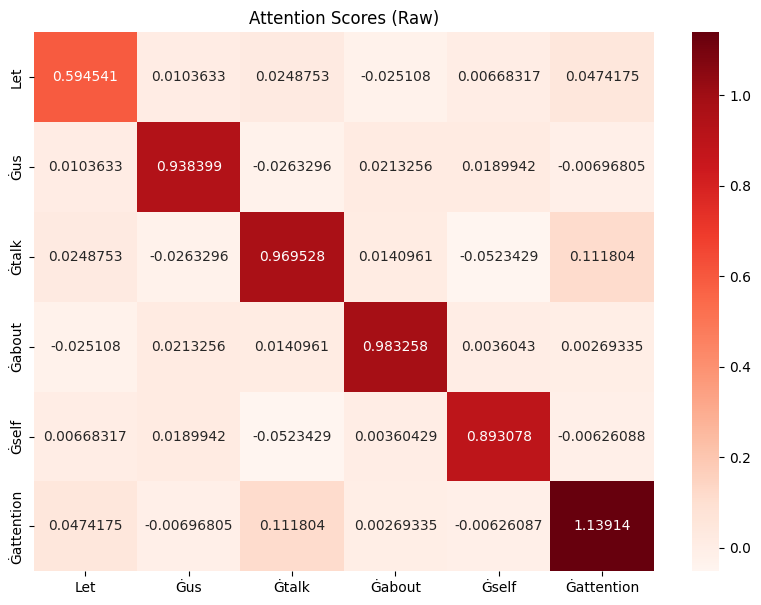

In [61]:
heat_mapper(attn_scores, "Attention Scores (Raw)", labels)

In [62]:
d_k = K_matrix.shape[-1]
attn_scores_normalized = attn_scores/d_k**0.5
attn_scores_normalized

tensor([[ 1.5170e-02,  2.6443e-04,  6.3471e-04, -6.4064e-04,  1.7052e-04,
          1.2099e-03],
        [ 2.6443e-04,  2.3944e-02, -6.7181e-04,  5.4413e-04,  4.8465e-04,
         -1.7779e-04],
        [ 6.3471e-04, -6.7181e-04,  2.4738e-02,  3.5967e-04, -1.3356e-03,
          2.8527e-03],
        [-6.4064e-04,  5.4413e-04,  3.5967e-04,  2.5088e-02,  9.1966e-05,
          6.8722e-05],
        [ 1.7052e-04,  4.8465e-04, -1.3356e-03,  9.1965e-05,  2.2787e-02,
         -1.5975e-04],
        [ 1.2099e-03, -1.7779e-04,  2.8527e-03,  6.8722e-05, -1.5975e-04,
          2.9066e-02]], grad_fn=<DivBackward0>)

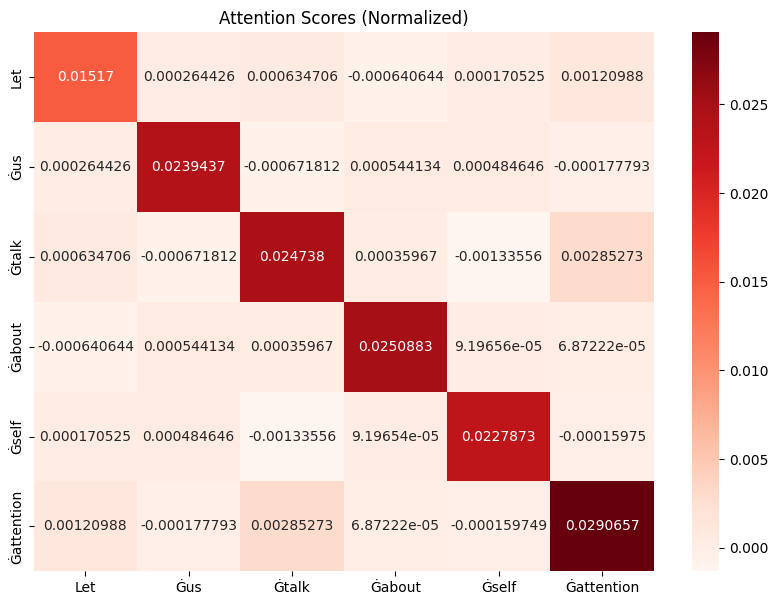

In [63]:
heat_mapper(attn_scores_normalized, "Attention Scores (Normalized)", labels)

In [64]:
attn_weights = torch.softmax(attn_scores_normalized, dim=-1)
attn_weights

tensor([[0.1687, 0.1662, 0.1663, 0.1661, 0.1662, 0.1664],
        [0.1660, 0.1700, 0.1659, 0.1661, 0.1661, 0.1660],
        [0.1660, 0.1658, 0.1701, 0.1660, 0.1657, 0.1664],
        [0.1658, 0.1660, 0.1660, 0.1702, 0.1660, 0.1660],
        [0.1661, 0.1661, 0.1658, 0.1661, 0.1699, 0.1660],
        [0.1659, 0.1657, 0.1662, 0.1658, 0.1657, 0.1706]],
       grad_fn=<SoftmaxBackward0>)

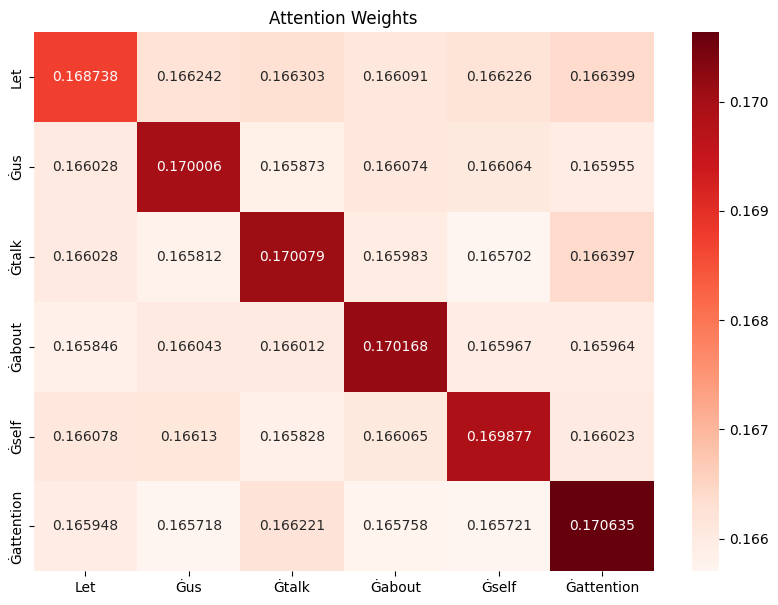

In [65]:
heat_mapper(attn_weights, "Attention Weights", labels)

In [67]:
# Sum to 1 across rows
np.sum(attn_weights.detach().numpy()[0])

np.float32(1.0)

In [68]:
# Column summation doesn't make sense
np.sum(attn_weights.detach().numpy()[:,1])

np.float32(0.9999497)

In [69]:
context_vec = attn_weights @ V_matrix
context_vec.shape

torch.Size([6, 1536])

In [70]:
context_vec

tensor([[-0.0172,  0.0032,  0.0115,  ..., -0.0079,  0.0110,  0.0042],
        [-0.0172,  0.0033,  0.0114,  ..., -0.0080,  0.0112,  0.0043],
        [-0.0172,  0.0033,  0.0114,  ..., -0.0079,  0.0110,  0.0041],
        [-0.0172,  0.0033,  0.0114,  ..., -0.0079,  0.0110,  0.0042],
        [-0.0173,  0.0033,  0.0115,  ..., -0.0080,  0.0109,  0.0042],
        [-0.0173,  0.0033,  0.0113,  ..., -0.0082,  0.0109,  0.0042]],
       grad_fn=<MmBackward0>)

### 3.4.2 Implementing a compact self-attention Python class

In [71]:
import torch.nn as nn
class SelfAttention_v1(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value
        attn_scores = queries @ keys.T # omega
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        context_vec = attn_weights @ values
        return context_vec
    

In [72]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs_book))

tensor([[ 0.0055, -0.0121],
        [ 0.0055, -0.0120],
        [ 0.0054, -0.0121],
        [ 0.0055, -0.0120],
        [ 0.0055, -0.0121],
        [ 0.0055, -0.0121]], grad_fn=<MmBackward0>)


#### Class improvement using nn.Linear
* nn.Linear effectively performs matrix multiplication when the bias units are disabled
* nn.Linear also has an optimized weight initialization scheme

In [73]:
class SelfAttention_v2(nn.Module):
    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        context_vec = attn_weights @ values
        return context_vec

In [74]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs_book))

tensor([[0.0008, 0.0019],
        [0.0008, 0.0019],
        [0.0008, 0.0019],
        [0.0008, 0.0019],
        [0.0008, 0.0019],
        [0.0008, 0.0019]], grad_fn=<MmBackward0>)


## Chapter 3.5 Hiding future words with causal attention
* Many LLM tasks only want the attention mechanism to consider tokens that appear before current position.
* Causal attention aka masked attention restricts model from knowing what's in the future, the inverse is true for standard self-attention where the model knows about past words and words to come.
* Essentially, what we'll be doing is masking out attention weights above the diagonal. If you remember LU decomposition we'll be left with the Lower part and mask out the Upper.

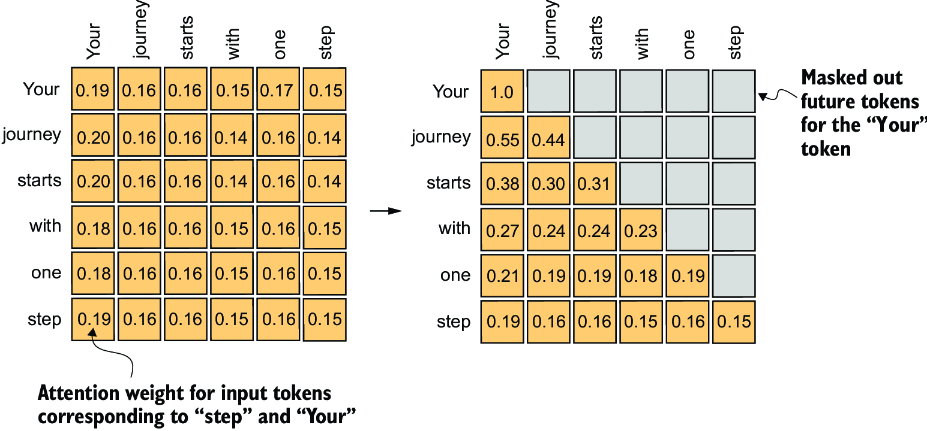

### 3.5.1 Applying a causal attention mask

#### Method 1:
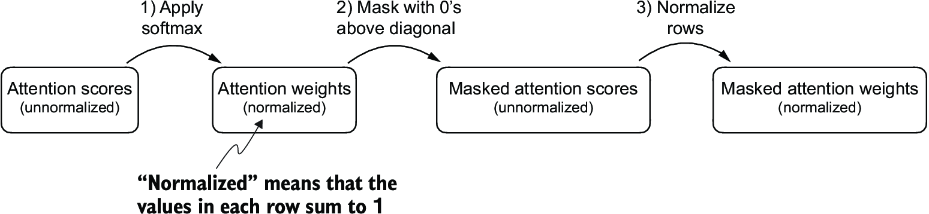

In [75]:
queries = sa_v2.W_query(inputs_book)
keys = sa_v2.W_key(inputs_book)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores/keys.shape[-1]**0.5, dim=-1)
attn_weights

tensor([[0.1667, 0.1667, 0.1666, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1666, 0.1667, 0.1667, 0.1667],
        [0.1666, 0.1667, 0.1666, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1666, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1666, 0.1667, 0.1667, 0.1667],
        [0.1667, 0.1667, 0.1666, 0.1667, 0.1667, 0.1667]],
       grad_fn=<SoftmaxBackward0>)

In [76]:
# Initial Mask
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length,context_length))
mask_simple

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])

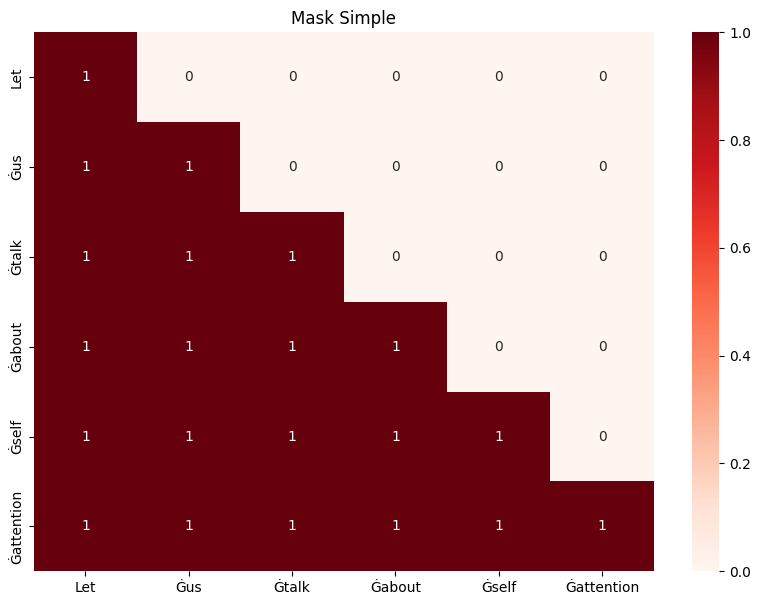

In [78]:
heat_mapper(mask_simple, "Mask Simple", labels)

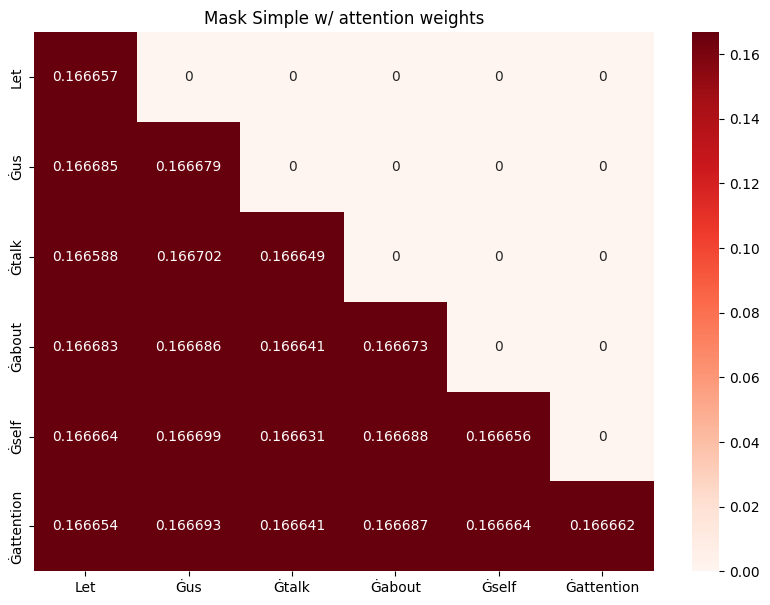

In [79]:
# Mask with attention weights
masked_simple = attn_weights*mask_simple
heat_mapper(masked_simple, "Mask Simple w/ attention weights", labels)

In [80]:
row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
masked_simple_norm

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3332, 0.3334, 0.3333, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000],
        [0.1667, 0.1667, 0.1666, 0.1667, 0.1667, 0.1667]],
       grad_fn=<DivBackward0>)

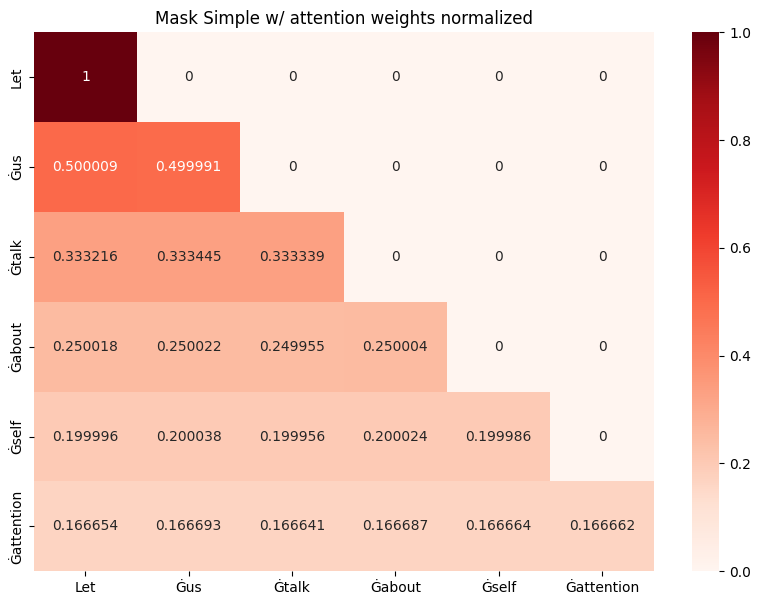

In [81]:
heat_mapper(masked_simple_norm, "Mask Simple w/ attention weights normalized", labels)

#### Information Leakage
* When masking no information about future tokens is leaked because the act of renormalization.
* After renormalization the distribution of attention weights is as if it was calculated only among the unmasked positions to begin with

#### Method 2:
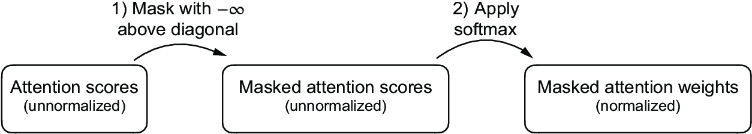

In [82]:
attn_scores

tensor([[-8.8690e-05,  1.7271e-04, -1.8810e-04,  1.2698e-04, -3.3557e-05,
         -4.2729e-05],
        [-3.4967e-04, -4.0039e-04, -6.6634e-04, -4.8772e-04, -6.2382e-04,
         -5.0459e-04],
        [ 6.4114e-04,  1.6099e-03,  1.1608e-03,  1.6948e-03,  1.5419e-03,
          1.1974e-03],
        [-3.8796e-04, -3.6441e-04, -7.4488e-04, -4.6816e-04, -6.5586e-04,
         -5.3503e-04],
        [-2.8604e-04,  1.2728e-05, -5.6877e-04, -8.7963e-05, -3.5564e-04,
         -3.0700e-04],
        [-9.4562e-05,  2.3606e-04, -2.0416e-04,  1.8284e-04, -1.2178e-05,
         -2.9419e-05]], grad_fn=<MmBackward0>)

In [83]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = torch.round(attn_scores,decimals=4).masked_fill(mask.bool(), -torch.inf)
masked

tensor([[-1.0000e-04,        -inf,        -inf,        -inf,        -inf,
                -inf],
        [-3.0000e-04, -4.0000e-04,        -inf,        -inf,        -inf,
                -inf],
        [ 6.0000e-04,  1.6000e-03,  1.2000e-03,        -inf,        -inf,
                -inf],
        [-4.0000e-04, -4.0000e-04, -7.0000e-04, -5.0000e-04,        -inf,
                -inf],
        [-3.0000e-04,  0.0000e+00, -6.0000e-04, -1.0000e-04, -4.0000e-04,
                -inf],
        [-1.0000e-04,  2.0000e-04, -2.0000e-04,  2.0000e-04, -0.0000e+00,
         -0.0000e+00]], grad_fn=<MaskedFillBackward0>)

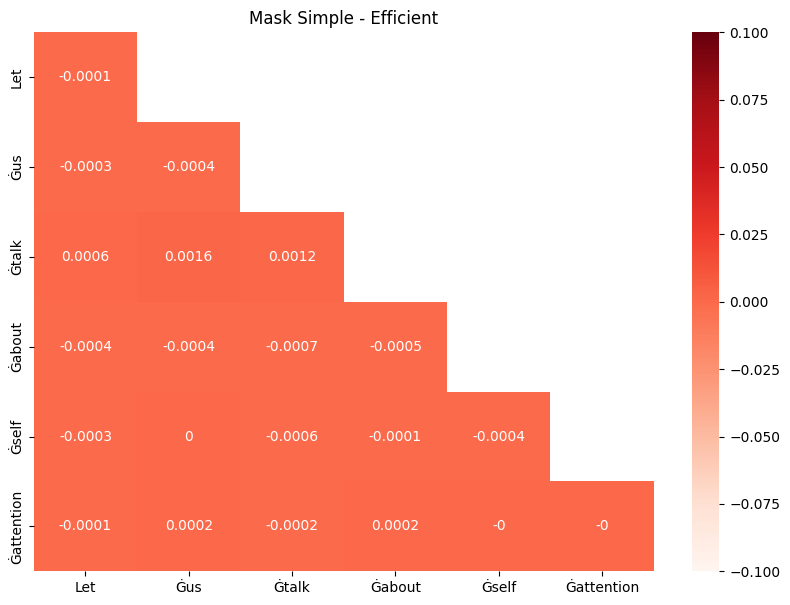

In [84]:
heat_mapper(masked, "Mask Simple - Efficient", labels)

Remember:
$$
\text{softmax}({x_i}) = \frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}}
$$

In [85]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
attn_weights

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3332, 0.3334, 0.3333, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000],
        [0.1667, 0.1667, 0.1666, 0.1667, 0.1667, 0.1667]],
       grad_fn=<SoftmaxBackward0>)

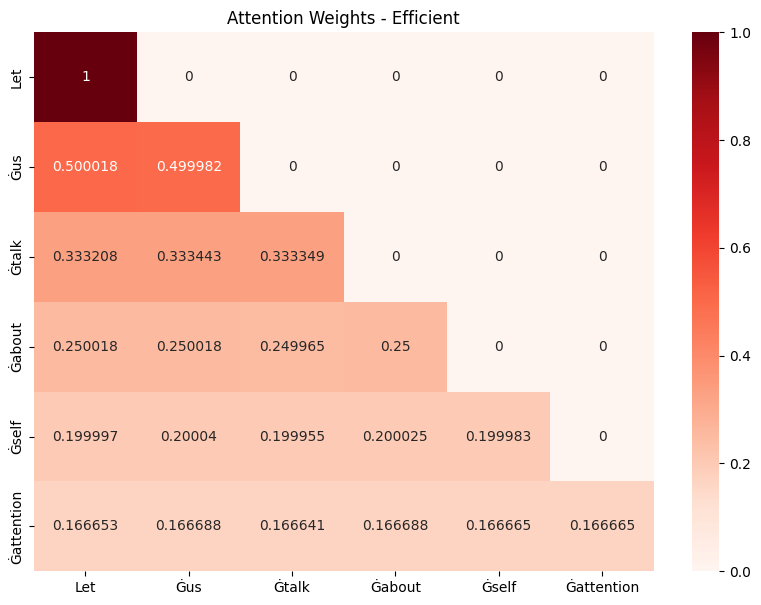

In [86]:
heat_mapper(attn_weights, "Attention Weights - Efficient", labels)

### 3.5.2 Masking additional attention weights with dropout

* Dropout in deep learning is a technique where randomly hidden layer units are ignored during training.
* Method is used in various types of models, not only LLMs, to help prevent overfitting.
* Additional note: Dropout is only used during training and is disabled afterward
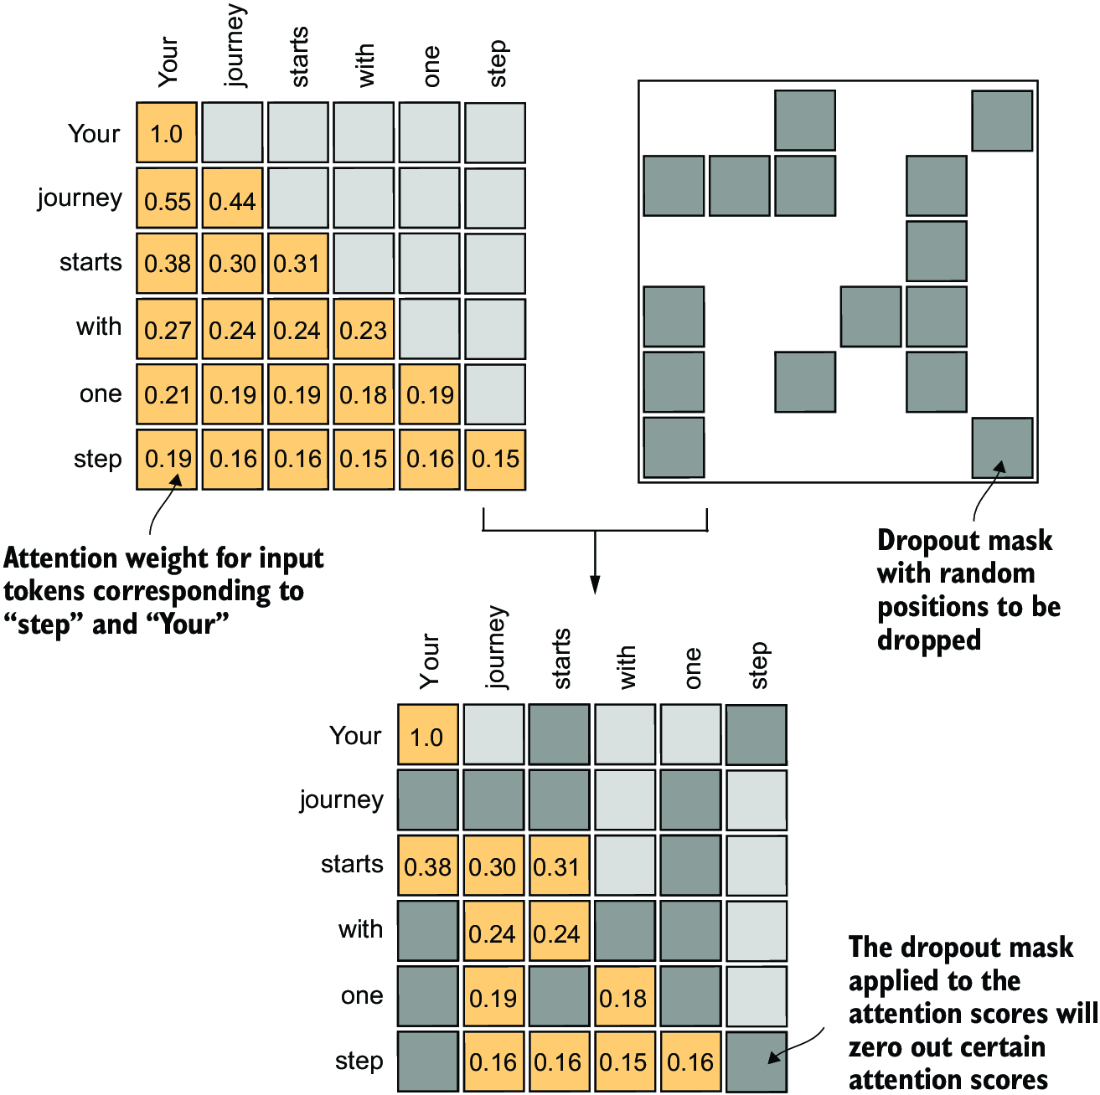

In [87]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)    #1
example = torch.ones(6, 6)      #2
print(dropout(example))

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])


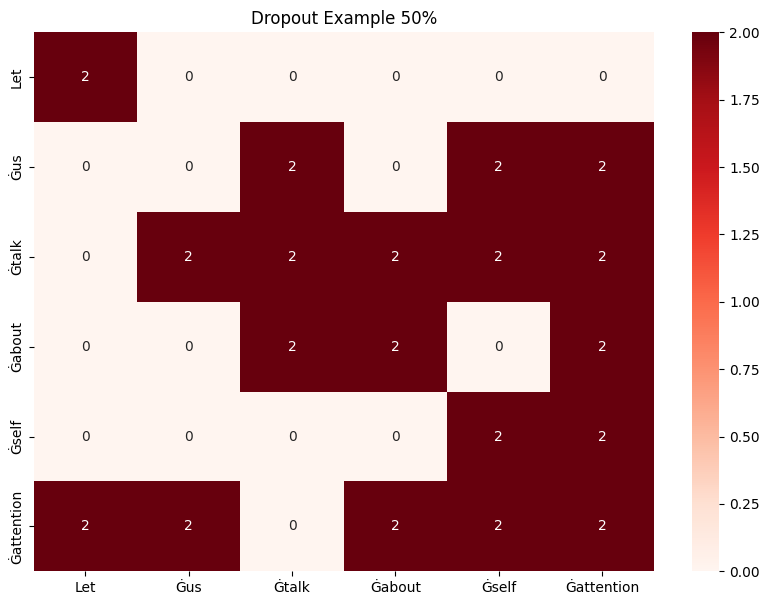

In [88]:
heat_mapper(dropout(example), "Dropout Example 50%", labels)

* When applying 50% dropout rate to attention weight matrix above half the elements are randomly set to zero.
* To compensate for this reduction in active elements, the remaining elements in the matrix are scaled up by a factor of
$$
1/0.5 = 2
$$  

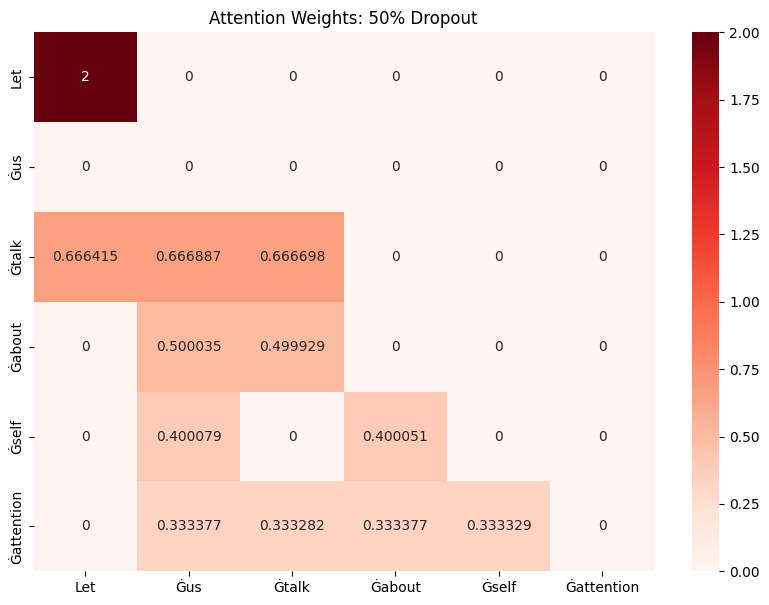

In [91]:
torch.manual_seed(123)
heat_mapper(dropout(attn_weights), "Attention Weights: 50% Dropout", labels)

### 3.5.3 Implementing a compact causal attention class

* Now we'll incorporate the causal attention and dropout modifications into the SelfAttention class developed in section 3.4.
* Let's setup batch handling for the CausalAttention class

In [92]:
# Batch simulator
batch = torch.stack((inputs_book,inputs_book), dim=0)
batch.shape

torch.Size([2, 6, 3])

In [93]:
class CausalAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length,
                dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)            #1
        self.register_buffer(
           'mask',
           torch.triu(torch.ones(context_length, context_length),
           diagonal=1)
        )             #2

    def forward(self, x):
        b, num_tokens, d_in = x.shape                   #3
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2)   
        attn_scores.masked_fill_(                    #4
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf) 
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights)

        context_vec = attn_weights @ values
        return context_vec

In [94]:
mask.bool()[:4,:4]

tensor([[False,  True,  True,  True],
        [False, False,  True,  True],
        [False, False, False,  True],
        [False, False, False, False]])

In [95]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
print(f"context_vecs.shape: {context_vecs.shape}")

context_vecs.shape: torch.Size([2, 6, 2])


### In summary:
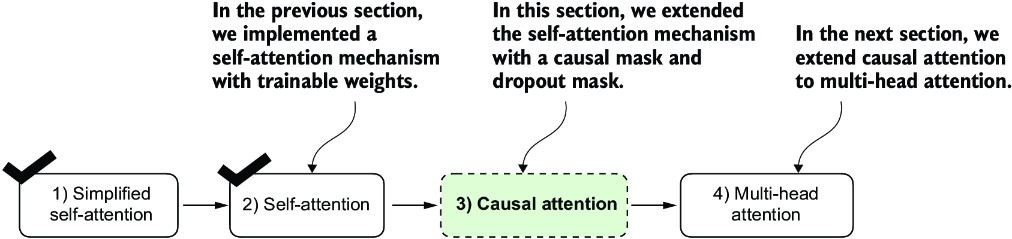